# U.S. Congress

In [117]:
import polars as pl
from plotnine import *
from mizani.formatters import label_comma, label_percent
from datetime import date

file = 'https://unitedstates.github.io/congress-legislators/legislators-current.csv'

df = pl.read_csv(file, schema_overrides={'birthday': pl.Date})

df = df.with_columns(
    ((date.today() - pl.col('birthday')).dt.total_days() / 365.25).alias('age'),
)

df[:4]

last_name,first_name,middle_name,suffix,nickname,full_name,birthday,gender,type,state,district,senate_class,party,url,address,phone,contact_form,rss_url,twitter,twitter_id,facebook,youtube,youtube_id,mastodon,bioguide_id,thomas_id,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id,age
str,str,str,str,str,str,date,str,str,str,i64,i64,str,str,str,str,str,str,str,i64,str,str,str,str,str,i64,str,str,str,i64,i64,i64,str,str,i64,str,f64
"""Cantwell""","""Maria""",null,null,null,"""Maria Cantwell""",1958-10-13,"""F""","""sen""","""WA""",null,1,"""Democrat""","""https://www.cantwell.senate.go…","""511 Hart Senate Office Buildin…","""202-224-3441""","""https://www.cantwell.senate.go…","""http://www.cantwell.senate.gov…","""SenatorCantwell""",117501995,"""senatorcantwell""","""SenatorCantwell""","""UCN52UDqKgvHRk39ncySrIMw""",null,"""C000127""",172,"""N00007836""","""S275""","""S8WA00194,H2WA01054""",26137,300018,27122,"""Maria Cantwell""",null,39310,"""Maria Cantwell""",66.984257
"""Klobuchar""","""Amy""","""Jean""",null,null,"""Amy Klobuchar""",1960-05-25,"""F""","""sen""","""MN""",null,1,"""Democrat""","""https://www.klobuchar.senate.g…","""425 Dirksen Senate Office Buil…","""202-224-3244""","""https://www.klobuchar.senate.g…",null,"""SenAmyKlobuchar""",22044727,null,"""senatorklobuchar""","""UCvdeJsDsV51tFb_hVqvtYGA""",null,"""K000367""",1826,"""N00027500""","""S311""","""S6MN00267""",83701,412242,65092,"""Amy Klobuchar""",null,40700,"""Amy Klobuchar""",65.368925
"""Sanders""","""Bernard""",null,null,"""Bernie""","""Bernard Sanders""",1941-09-08,"""M""","""sen""","""VT""",null,1,"""Independent""","""https://www.sanders.senate.gov""","""332 Dirksen Senate Office Buil…","""202-224-5141""","""https://www.sanders.senate.gov…","""http://www.sanders.senate.gov/…","""SenSanders""",29442313,"""senatorsanders""","""senatorsanders""","""UCD_DaKNac0Ta-2PeHuoQ1uA""",null,"""S000033""",1010,"""N00000528""","""S313""","""H8VT01016,S4VT00033""",994,400357,27110,"""Bernie Sanders""",null,29147,"""Bernie Sanders""",84.079398
"""Whitehouse""","""Sheldon""",null,null,null,"""Sheldon Whitehouse""",1955-10-20,"""M""","""sen""","""RI""",null,1,"""Democrat""","""https://www.whitehouse.senate.…","""530 Hart Senate Office Buildin…","""202-224-2921""","""https://www.whitehouse.senate.…","""http://www.whitehouse.senate.g…","""SenWhitehouse""",242555999,"""SenatorWhitehouse""","""SenatorWhitehouse""","""UCnG0N70SNBkNqvIMLodPTIA""",null,"""W000802""",1823,"""N00027533""","""S316""","""S6RI00221""",92235,412247,2572,"""Sheldon Whitehouse""",null,40704,"""Sheldon Whitehouse""",69.965777


## Gender Breakdown

party,gender,count
str,str,u32
"""Democrat""","""F""",112
"""Republican""","""F""",43
"""Republican""","""M""",232
"""Democrat""","""M""",149
"""Independent""","""M""",2


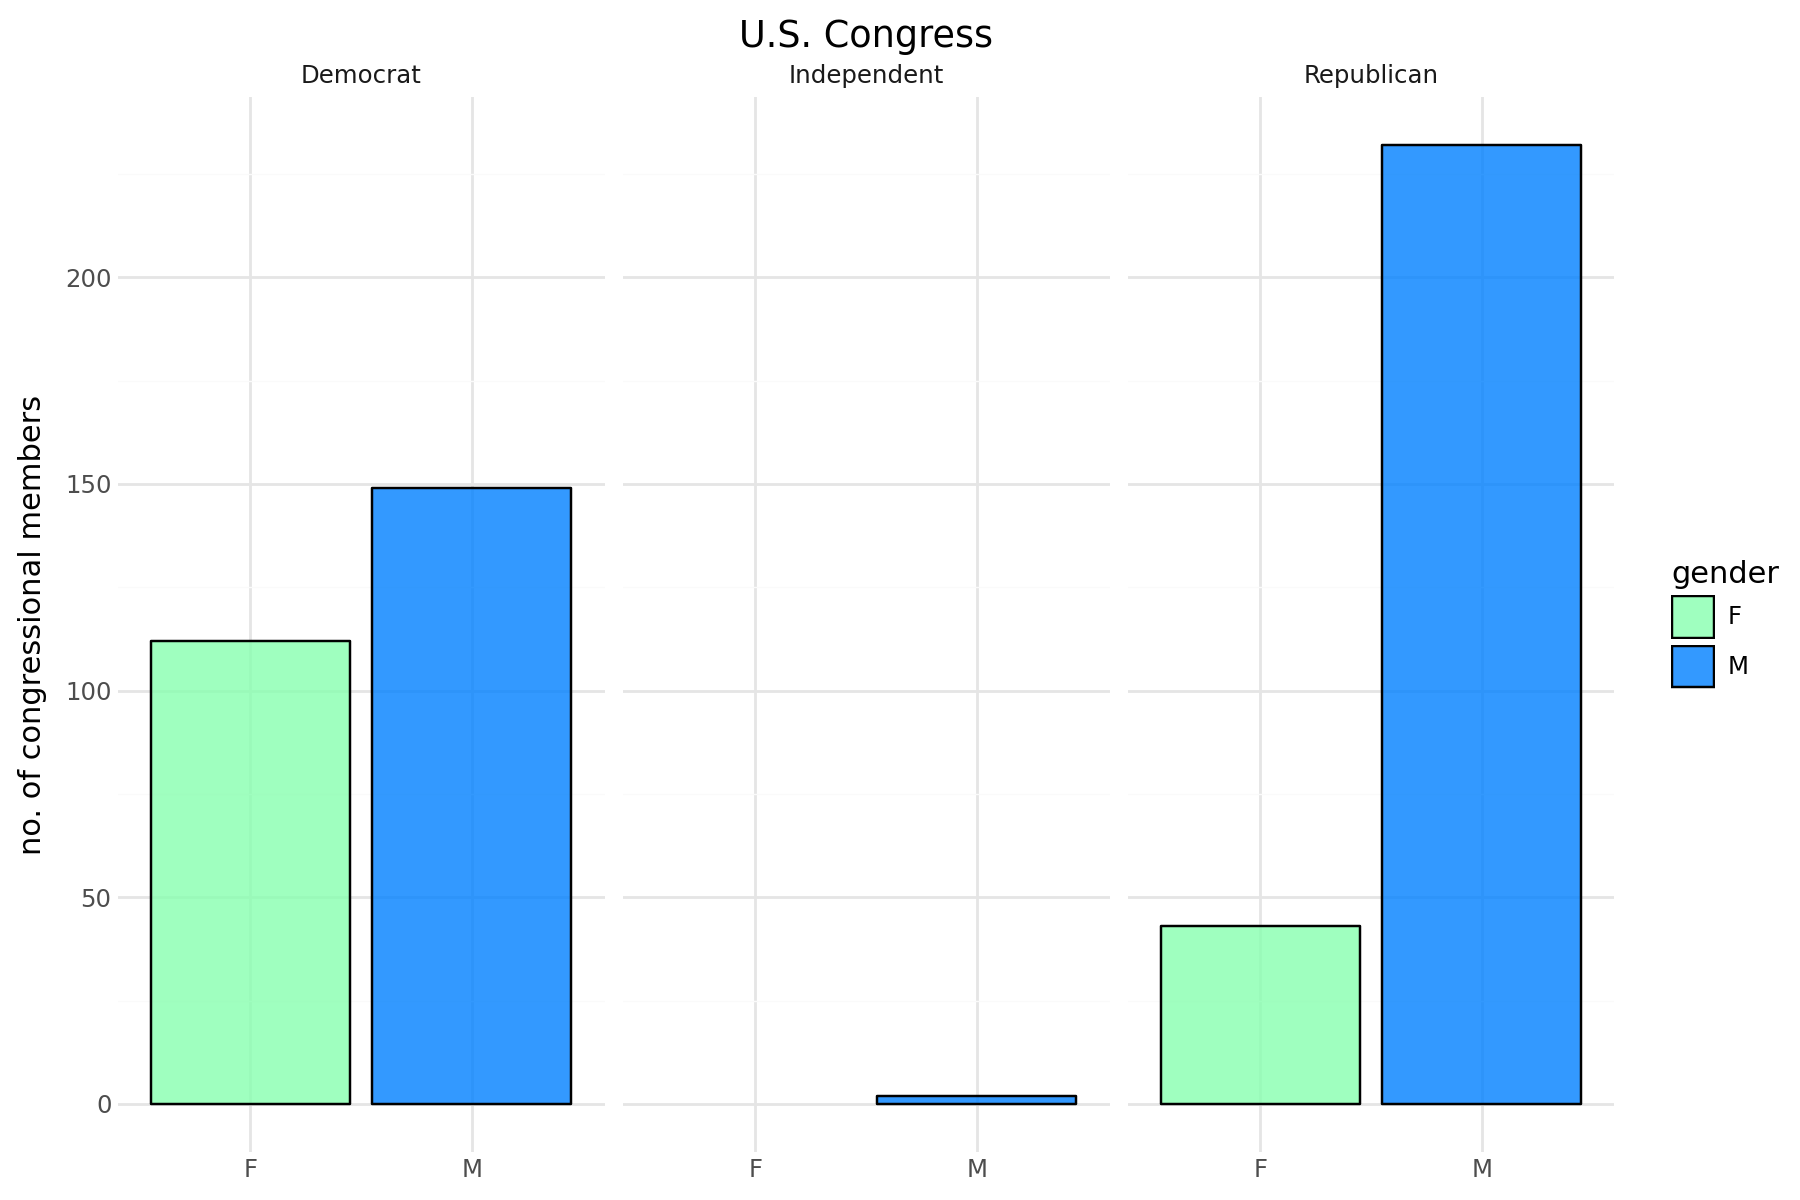

In [133]:
df_party_gender_agg = (
    df
    .group_by('party', 'gender')
    .agg(pl.len().alias('count'))
)

display(df_party_gender_agg)

(
    ggplot(df_party_gender_agg, aes(x='gender', y='count'))
    + geom_col(aes(fill='gender'), color='black', alpha=0.8)
    + facet_wrap('party')
    + scale_fill_manual(['#87ffaf', '#0080ff'])
    + labs(
        title='U.S. Congress',
        x='',
        y='no. of congressional members',
    )
    + theme_minimal()
    + theme(figure_size=(9,6))
)

party,gender,count,percentage
str,str,u32,f64
"""Republican""","""F""",43,0.156364
"""Republican""","""M""",232,0.843636
"""Democrat""","""F""",112,0.429119
"""Independent""","""M""",2,1.0
"""Democrat""","""M""",149,0.570881


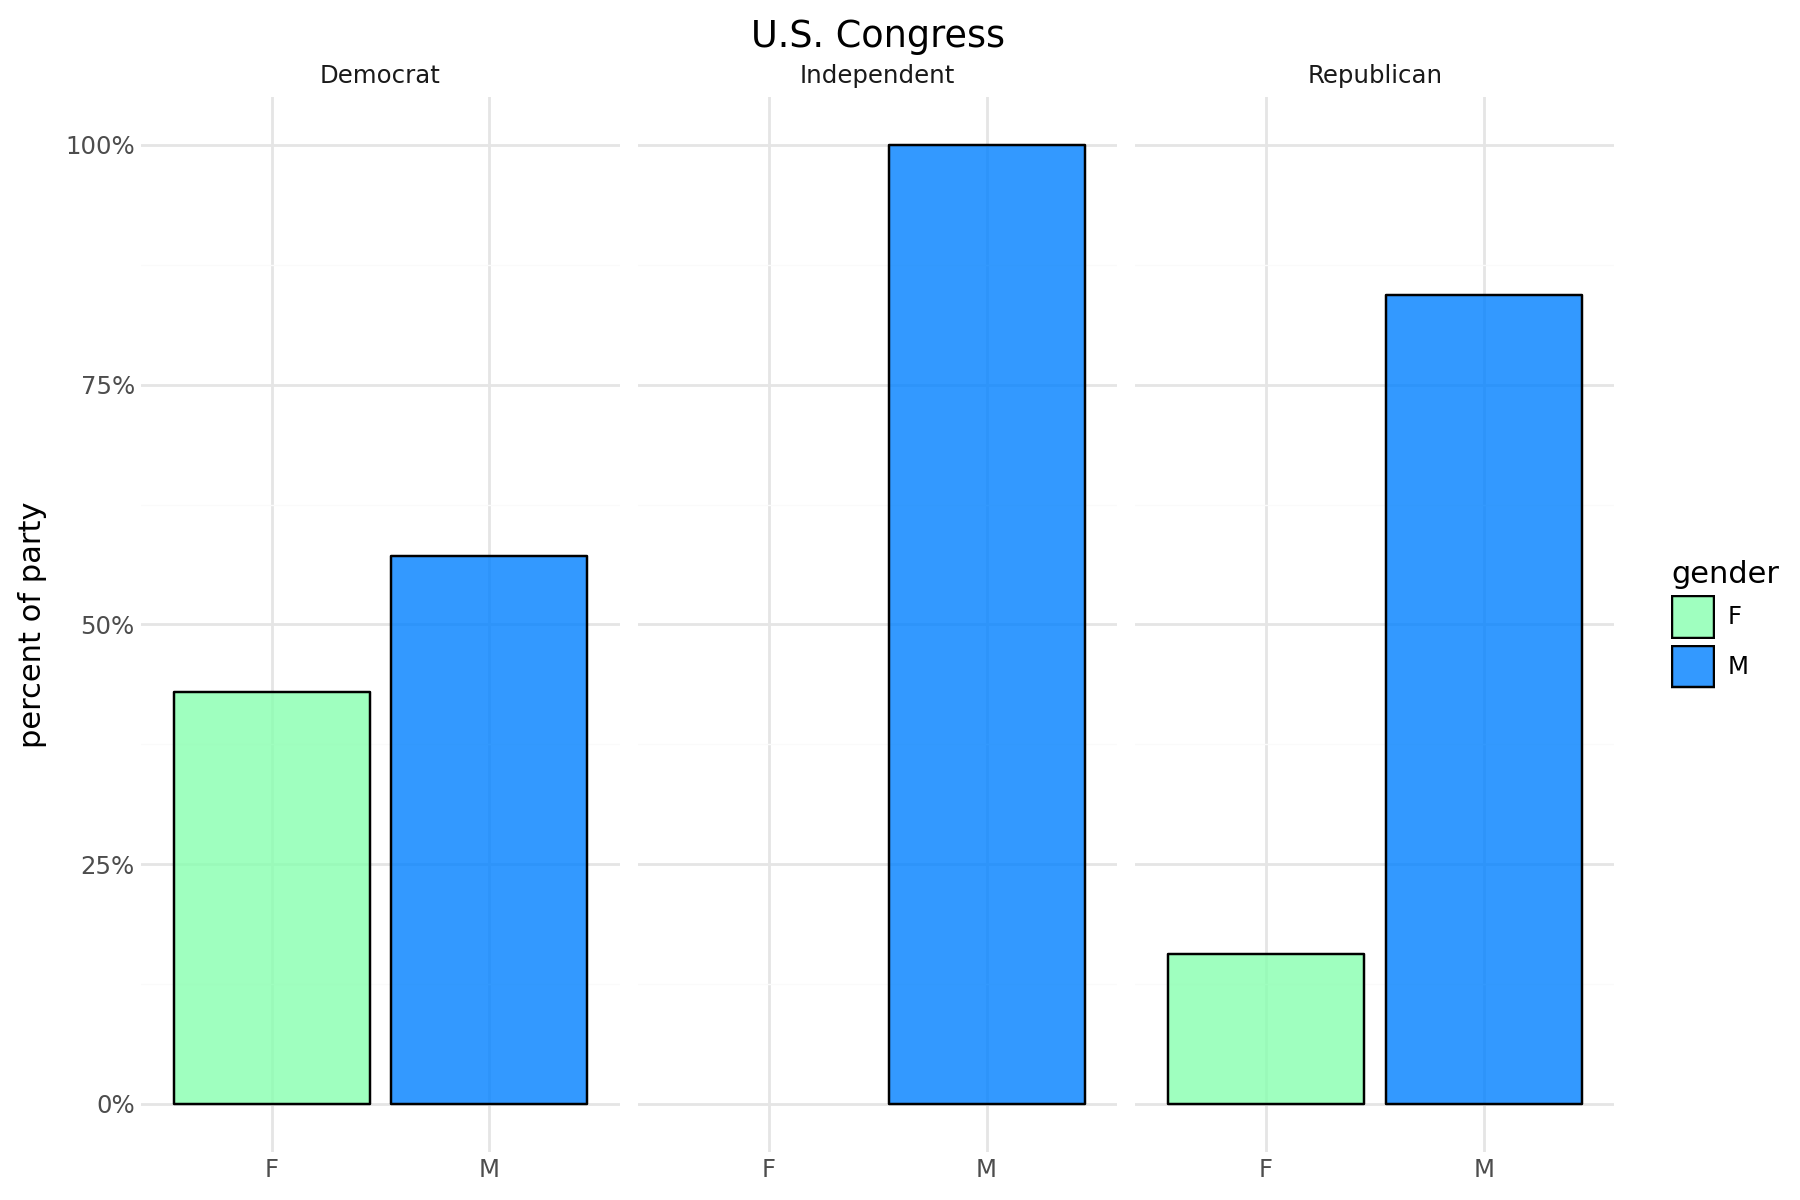

In [132]:
df_party_members = df_party_gender_agg.group_by('party').agg(pl.sum('count'))

df_party_gender_agg = (
    df_party_gender_agg
    .join(df_party_members, on='party')
    .rename({'count_right': 'party_total'})
    .select(
        pl.col('party'),
        pl.col('gender'),
        pl.col('count'),
        (pl.col('count') / pl.col('party_total')).alias('percentage')
    )
)

display(df_party_gender_agg)

(
    ggplot(df_party_gender_agg, aes(x='gender', y='percentage'))
    + geom_col(aes(fill='gender'), color='black', alpha=0.8)
    + facet_wrap('party')
    + scale_y_continuous(labels=label_percent())
    + scale_fill_manual(['#87ffaf', '#0080ff'])
    + labs(
        title='U.S. Congress',
        x='',
        y='percent of party',
    )
    + theme_minimal()
    + theme(figure_size=(9,6))
)

## Age

full_name,nickname,gender,birthday,state,party,age
str,str,str,date,str,str,f64
"""Chuck Grassley""","""Chuck""","""M""",1933-09-17,"""IA""","""Republican""",92.05
"""Eleanor Holmes Norton""",null,"""F""",1937-06-13,"""DC""","""Democrat""",88.32
"""Harold Rogers""","""Hal""","""M""",1937-12-31,"""KY""","""Republican""",87.77
"""Maxine Waters""",null,"""F""",1938-08-15,"""CA""","""Democrat""",87.15
"""Steny H. Hoyer""",null,"""M""",1939-06-14,"""MD""","""Democrat""",86.32
"""Nancy Pelosi""",null,"""F""",1940-03-26,"""CA""","""Democrat""",85.53
"""James E. Clyburn""","""Jim""","""M""",1940-07-21,"""SC""","""Democrat""",85.21
"""Bernard Sanders""","""Bernie""","""M""",1941-09-08,"""VT""","""Independent""",84.08
"""Danny K. Davis""",null,"""M""",1941-09-06,"""IL""","""Democrat""",84.08


full_name,nickname,gender,birthday,state,party,age
str,str,str,date,str,str,f64
"""Anna Paulina Luna""",null,"""F""",1989-05-06,"""FL""","""Republican""",36.42
"""Alexandria Ocasio-Cortez""",null,"""F""",1989-10-13,"""NY""","""Democrat""",35.98
"""Robert P. Bresnahan, Jr.""",null,"""M""",1990-04-22,"""PA""","""Republican""",35.46
"""Sarah McBride""",null,"""F""",1990-08-09,"""DE""","""Democrat""",35.16
"""Pablo José Hernández""",null,"""M""",1991-05-11,"""PR""","""Democrat""",34.41
"""Abraham J. Hamadeh""",null,"""M""",1991-05-15,"""AZ""","""Republican""",34.4
"""Yassamin Ansari""",null,"""F""",1992-04-07,"""AZ""","""Democrat""",33.5
"""Addison P. McDowell""",null,"""M""",1994-01-21,"""NC""","""Republican""",31.71
"""Brandon Gill""",null,"""M""",1994-02-26,"""TX""","""Republican""",31.61


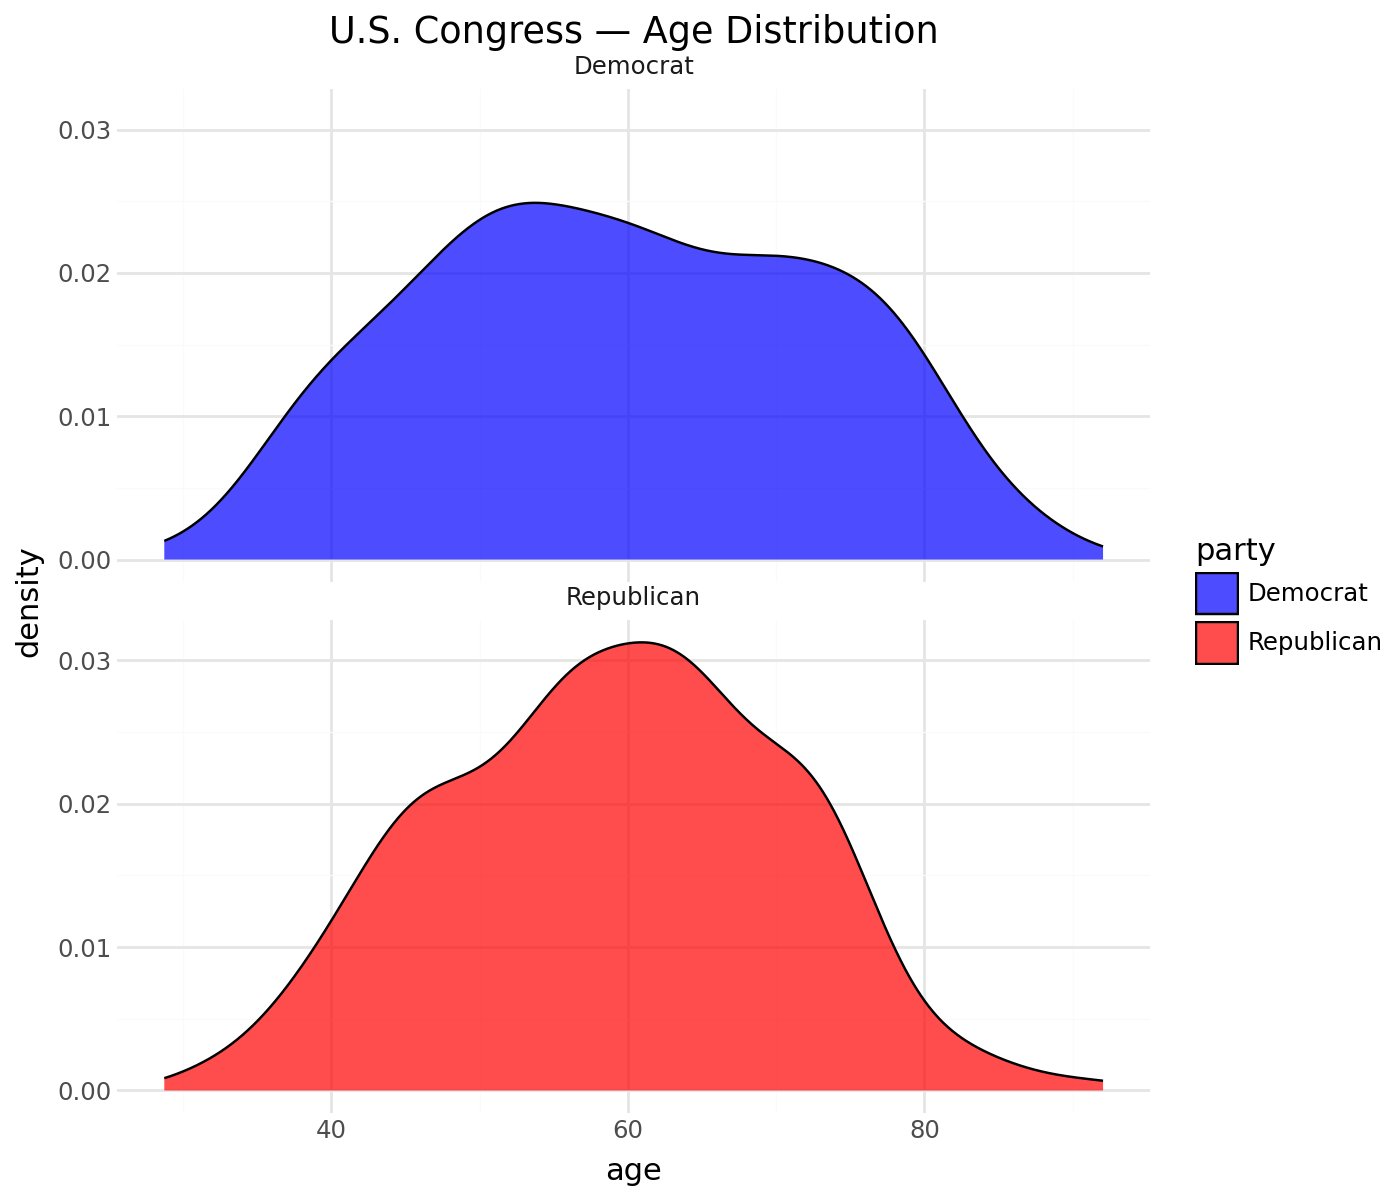

In [174]:
display(
    df
    .select(
        pl.col('full_name'),
        pl.col('nickname'),
        pl.col('gender'),
        pl.col('birthday'),
        pl.col('state'),
        pl.col('party'),
        pl.col('age').round(2),

    )
    .sort('age', descending=True)
    .head(10)
)

display(
    df
    .select(
        pl.col('full_name'),
        pl.col('nickname'),
        pl.col('gender'),
        pl.col('birthday'),
        pl.col('state'),
        pl.col('party'),
        pl.col('age').round(2),

    )
    .sort('age', descending=True)
    .tail(10)
)

(
    ggplot(df.filter(pl.col('party').is_in(['Democrat', 'Republican'])), aes(x='age'))
    + geom_density(aes(fill='party'), color='black', alpha=0.7)
    + scale_fill_manual(['blue', 'red'])
    + facet_wrap('party', ncol=1)
    + labs(
        title='U.S. Congress — Age Distribution',
        x='age',
        y='density',
    )
    + theme_minimal()
    + theme(figure_size=(7,6))
)